# Movies Dataset: Modeling Exercise

In [1]:
import numpy as np
import pandas as pd

import acquire
import prepare

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from vega_datasets import data

## Acquire

In [2]:
df = data('movies')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Title                   3200 non-null   object 
 1   US Gross                3194 non-null   float64
 2   Worldwide Gross         3194 non-null   float64
 3   US DVD Sales            564 non-null    float64
 4   Production Budget       3200 non-null   float64
 5   Release Date            3201 non-null   object 
 6   MPAA Rating             2596 non-null   object 
 7   Running Time min        1209 non-null   float64
 8   Distributor             2969 non-null   object 
 9   Source                  2836 non-null   object 
 10  Major Genre             2926 non-null   object 
 11  Creative Type           2755 non-null   object 
 12  Director                1870 non-null   object 
 13  Rotten Tomatoes Rating  2321 non-null   float64
 14  IMDB Rating             2988 non-null   

In [4]:
df.head(2)

,Title,US Gross,Worldwide Gross,US DVD Sales,Production Budget,Release Date,MPAA Rating,Running Time min,Distributor,Source,Major Genre,Creative Type,Director,Rotten Tomatoes Rating,IMDB Rating,IMDB Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0


## Prepare

In [5]:
#rename columns 
df.columns = [column.lower() for column in df]

In [6]:
# replace space with underscore
df.columns = df.columns.str.replace(' ','_')

In [7]:
# drop columns
df = df.drop(columns=['us_gross', 'us_dvd_sales', 'mpaa_rating', 
                 'running_time_min', 'source', 'major_genre',
                'creative_type', 'director', 'distributor', 
                 'rotten_tomatoes_rating', 'imdb_rating'])

In [8]:
# set date to datetime type and set as index
df.release_date = pd.to_datetime(df.release_date)
df = df.set_index('release_date').sort_index()
df.head(2)

,title,worldwide_gross,production_budget,imdb_votes
release_date,,,,
1928-12-31,The Broadway Melody,4358000.0,379000.0,2017.0
1929-12-31,Hell's Angels,NaN,4000000.0,2050.0


In [9]:
# drop nulls
df = df.dropna()
df.isnull().sum()

title                0
worldwide_gross      0
production_budget    0
imdb_votes           0
dtype: int64

In [10]:
# create net revenue column
df['net_revenue'] = df.worldwide_gross - df.production_budget

In [11]:
# drop gross and production budget
df = df.drop(columns=['worldwide_gross', 'production_budget', 'title'])

In [12]:
# check latest and earliest dates
df.index.min(), df.index.max()

(Timestamp('1928-12-31 00:00:00'), Timestamp('2046-12-31 00:00:00'))

In [13]:
# Dates are incorrect 
df[-15:-1]

,imdb_votes,net_revenue
release_date,,
2025-01-01,2600.0,21755000.0
2025-12-30,58510.0,5100000.0
2033-02-09,1795.0,1800000.0
2033-03-09,4263.0,1861000.0
2036-02-05,35773.0,-1336755.0
2037-12-21,38141.0,183437485.0
2039-08-25,102795.0,25425232.0
2039-12-15,78947.0,386625192.0
2040-11-13,29914.0,81040000.0


In [14]:
(df.index.value_counts() == 0).sum()

0

In [15]:
# filter data from 1980 to 2010
df = df['1976':'2009']

In [16]:
# resample by month and take the sum
df = df.resample('M').sum()

### Split the Data

In [17]:
train_size = int(len(df) * .7)
validate_size = int(len(df) * .1)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [18]:
train.shape, validate.shape, test.shape

((284, 2), (40, 2), (83, 2))

In [19]:
train.head()

,imdb_votes,net_revenue
release_date,,
1976-02-29,155774.0,20100000.0
1976-03-31,4800.0,3000000.0
1976-04-30,7290.0,10200000.0
1976-05-31,0.0,0.0
1976-06-30,30771.0,77516580.0


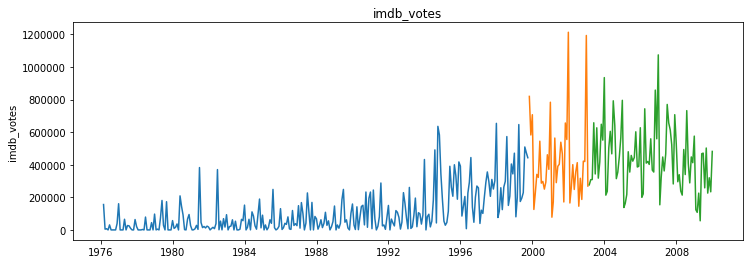

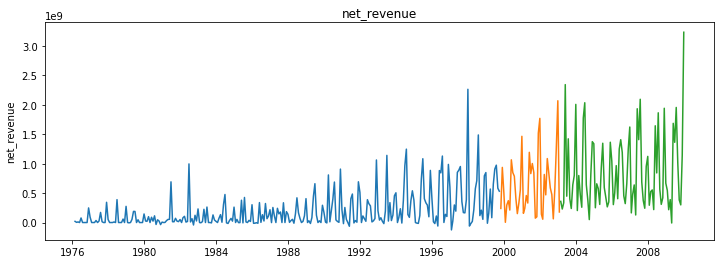

In [20]:
# train, validate, test plot
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

functions

In [21]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [22]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [23]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Modeling

### Simple Average

**Predictions**

In [24]:
rev = round(train['net_revenue'].mean(),2)
votes = round(train['imdb_votes'].mean(),2)

In [25]:
print('Average revenue \n', rev)
print('Average Number of votes \n', votes)

Average revenue 
 194403308.94
Average Number of votes 
 104815.73


In [26]:
# uses the model to make predictions in a df
def make_predictions():
    yhat_df = pd.DataFrame({'net_revenue': [rev],
                            'imdb_votes': [votes]}, 
                           index = validate.index)
    return yhat_df

In [27]:
yhat_df = make_predictions()

In [28]:
yhat_df.head()

,net_revenue,imdb_votes
release_date,,
1999-10-31,1.944033e+08,104815.73
1999-11-30,1.944033e+08,104815.73
1999-12-31,1.944033e+08,104815.73
2000-01-31,1.944033e+08,104815.73
2000-02-29,1.944033e+08,104815.73


**Plot: Actual vs. Predicted**

imdb_votes -- RMSE: 401177


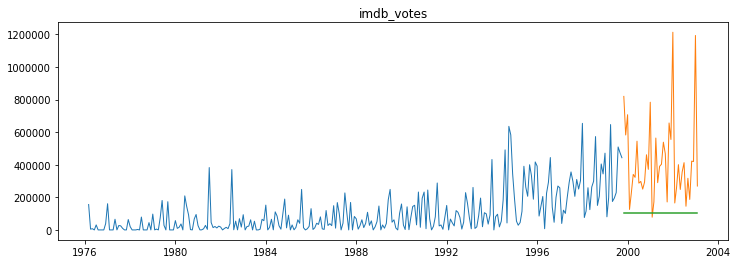

net_revenue -- RMSE: 664610040


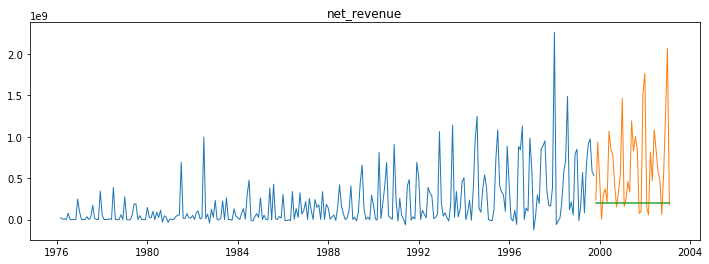

In [29]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [30]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)

In [31]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,simple_average,imdb_votes,401177.0
1,simple_average,net_revenue,664610040.0


Takeaways: 
- simple average is probably not a good model
- doesn't seem to be useful with real world data
- when would this model be useful?
- maybe linear or straight forward data

### Holt's Linear Trend: Basic

imdb_votes 



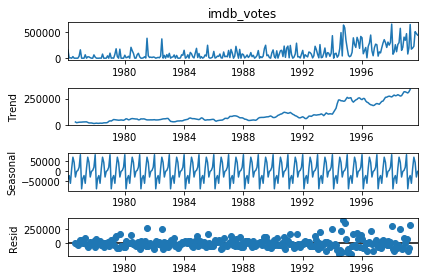

net_revenue 



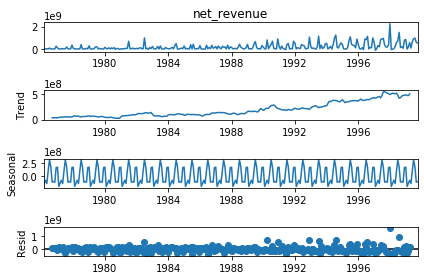

In [32]:
# Seasonal Decomposition
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

**Predictions**

In [33]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [34]:
yhat_df.head()

,net_revenue,imdb_votes
release_date,,
1999-10-31,4.774345e+08,342908.72
1999-11-30,4.774345e+08,343998.52
1999-12-31,4.774345e+08,344597.88
2000-01-31,4.774345e+08,344927.51
2000-02-29,4.774345e+08,345108.80


**Plot: Actual vs. Predicted**

imdb_votes -- RMSE: 261482


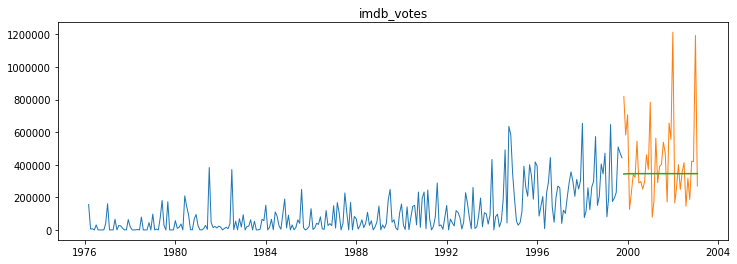

net_revenue -- RMSE: 522848129


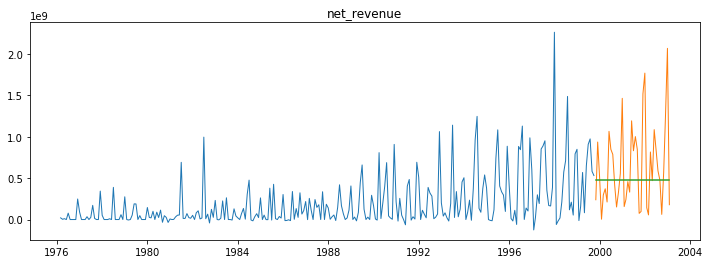

In [35]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [36]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [37]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,holts_optimized,imdb_votes,261482.0
0,simple_average,imdb_votes,401177.0
3,holts_optimized,net_revenue,522848129.0
1,simple_average,net_revenue,664610040.0


### Holt's Alternate Version

**Predictions**

In [38]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=.1, 
                      smoothing_slope=.1, 
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [39]:
yhat_df.head()

,net_revenue,imdb_votes
release_date,,
1999-10-31,5.583103e+08,366492.22
1999-11-30,5.640369e+08,373201.24
1999-12-31,5.697636e+08,379910.25
2000-01-31,5.754902e+08,386619.26
2000-02-29,5.812168e+08,393328.28


**Plot: Actual vs. Predicted**

imdb_votes -- RMSE: 273619


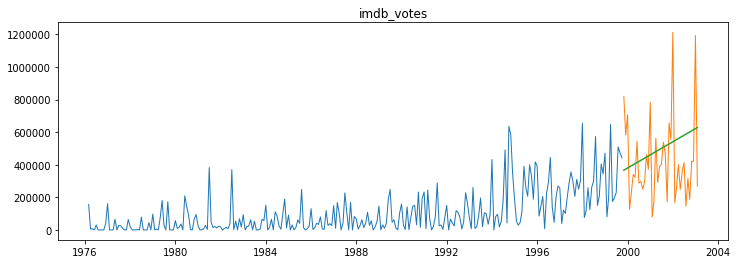

net_revenue -- RMSE: 489602995


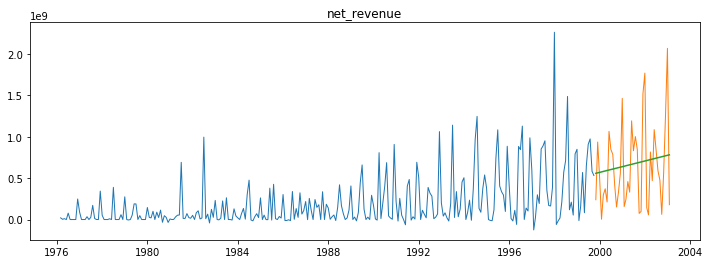

In [40]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [41]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)

In [42]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,holts_optimized,imdb_votes,261482.0
4,holts_.1,imdb_votes,273619.0
0,simple_average,imdb_votes,401177.0
5,holts_.1,net_revenue,489602995.0
3,holts_optimized,net_revenue,522848129.0
1,simple_average,net_revenue,664610040.0


### Moving Average

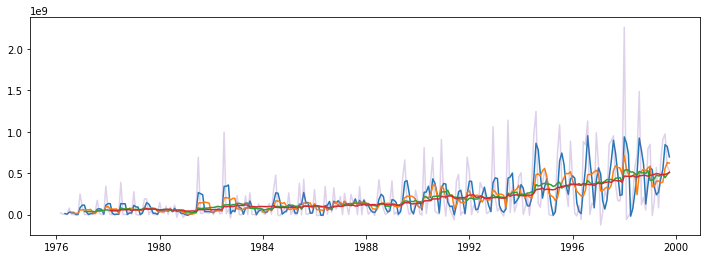

In [43]:
# rolling avg by months
plt.figure(figsize=(12,4))
plt.plot(train['net_revenue'].rolling(3).mean())
plt.plot(train['net_revenue'].rolling(6).mean())
plt.plot(train['net_revenue'].rolling(12).mean())
plt.plot(train['net_revenue'].rolling(24).mean())
plt.plot(train['net_revenue'], alpha=.3)

**Predictions**

In [44]:
# only for 24 month period
period = 24

rev = round(train['net_revenue'].rolling(period).mean()[-1], 2)
votes = round(train['imdb_votes'].rolling(period).mean()[-1], 2)

print(rev, votes)

508717458.92 310143.79


**Plot: Actual vs. Predicted**

imdb_votes -- RMSE: 273619


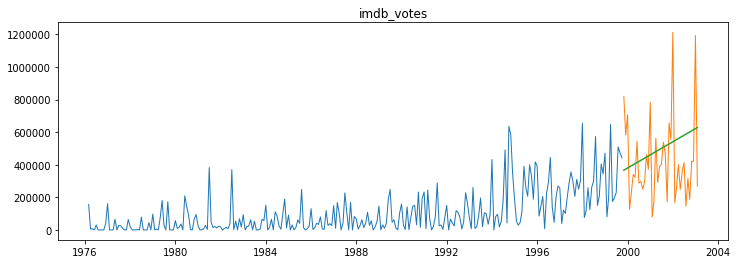

net_revenue -- RMSE: 489602995


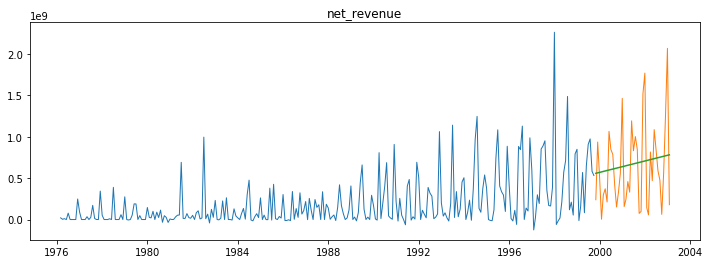

In [45]:
# only for 24 month period
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [46]:
# evaluate for several periods
periods = [3, 6, 9, 12, 18, 24]

for p in periods: 
    rev = round(train['net_revenue'].rolling(p).mean()[-1], 2)
    votes = round(train['imdb_votes'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + 'm_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [47]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
6,3m_moving_avg,imdb_votes,257612.0
12,12m_moving_avg,imdb_votes,260750.0
2,holts_optimized,imdb_votes,261482.0
8,6m_moving_avg,imdb_votes,263612.0
10,9m_moving_avg,imdb_votes,266723.0
14,18m_moving_avg,imdb_votes,268919.0
16,24m_moving_avg,imdb_votes,273169.0
4,holts_.1,imdb_votes,273619.0
0,simple_average,imdb_votes,401177.0
5,holts_.1,net_revenue,489602995.0


### Previous Cycle

In [48]:
#resplit
train = df[:'2007']
validate = df['2008']
test = df['2009']

print(train.shape[0], format(train.shape[0]/len(df),'.0%'))
print(validate.shape[0], format(validate.shape[0]/len(df),'.0%'))
print(test.shape[0], format(test.shape[0]/len(df),'.0%'))

train.head()

383 94%
12 3%
12 3%


,imdb_votes,net_revenue
release_date,,
1976-02-29,155774.0,20100000.0
1976-03-31,4800.0,3000000.0
1976-04-30,7290.0,10200000.0
1976-05-31,0.0,0.0
1976-06-30,30771.0,77516580.0


**Predictions**

In [49]:
yhat_df = train['2007'] + train.diff(12).mean()

In [50]:
yhat_df.index = validate.index

yhat_df.describe()

,imdb_votes,net_revenue
count,12.000000,1.200000e+01
mean,500587.258985,8.788105e+08
std,184433.858265,6.682182e+08
min,168700.342318,1.545922e+08
25%,366472.342318,3.686717e+08
50%,509350.842318,6.895924e+08
75%,638703.342318,1.220954e+09
max,784773.342318,2.120205e+09


In [51]:
yhat_df.head()

,imdb_votes,net_revenue
release_date,,
2008-01-31,168700.342318,1.898525e+08
2008-02-29,336079.342318,5.065480e+08
2008-03-31,462182.342318,6.649191e+08
2008-04-30,376603.342318,1.545922e+08
2008-05-31,480869.342318,1.959557e+09


In [52]:
yhat_df.shape

(12, 2)

**Plot: Actual vs. Predicted**

imdb_votes -- RMSE: 209028


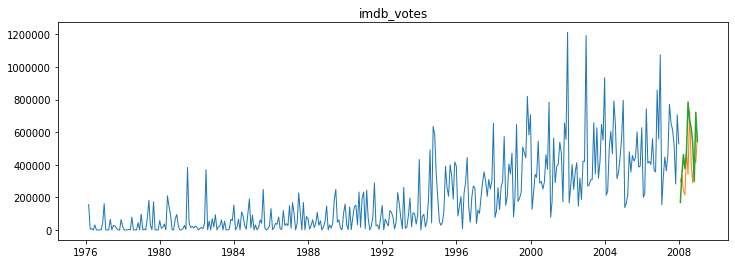

net_revenue -- RMSE: 381860808


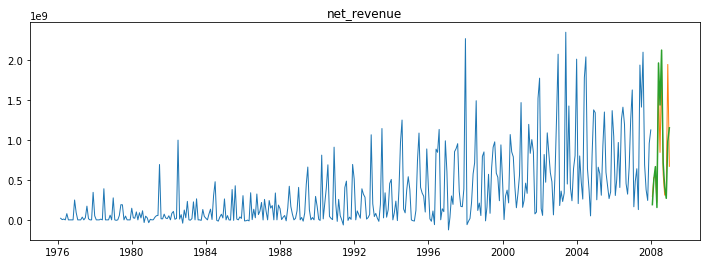

In [53]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_month", 
                            target_var = col)

In [54]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
18,previous_month,imdb_votes,209028.0
6,3m_moving_avg,imdb_votes,257612.0
12,12m_moving_avg,imdb_votes,260750.0
2,holts_optimized,imdb_votes,261482.0
8,6m_moving_avg,imdb_votes,263612.0
10,9m_moving_avg,imdb_votes,266723.0
14,18m_moving_avg,imdb_votes,268919.0
16,24m_moving_avg,imdb_votes,273169.0
4,holts_.1,imdb_votes,273619.0
0,simple_average,imdb_votes,401177.0


# Conclusion

- Previous Cycle Model is best

In [55]:
rev_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

votes_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == rev_rmse) | 
         (eval_df.rmse == votes_rmse))]

,model_type,target_var,rmse
18,previous_month,imdb_votes,209028.0
19,previous_month,net_revenue,381860808.0


**Test on out of sample**

In [56]:
# use train and validate to predict test
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [57]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

rmse_rev = sqrt(mean_squared_error(test['net_revenue'], 
                                       yhat_df['net_revenue']))

rmse_votes = sqrt(mean_squared_error(test['imdb_votes'], 
                                       yhat_df['imdb_votes']))

In [58]:
print('RMSE Net Revenue: ', rmse_rev)
print('RMSE IMDB Votes: ', rmse_votes)

RMSE Net Revenue:  807771446.8916448
RMSE IMDB Votes:  196098.85921661122


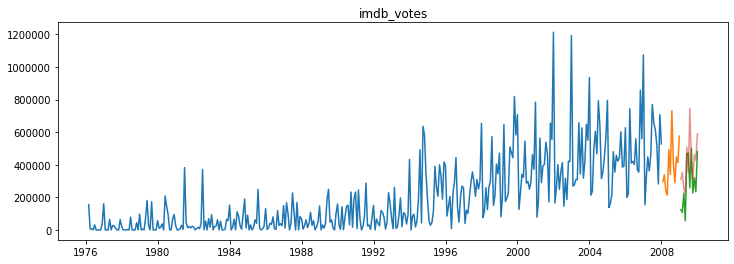

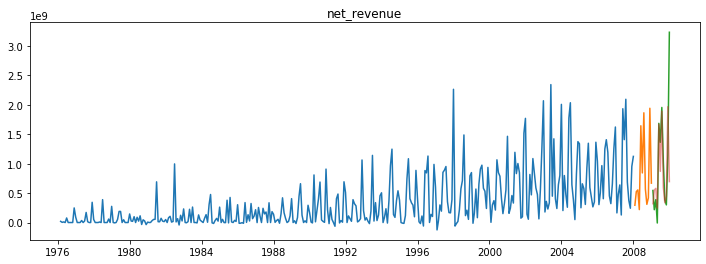

In [59]:
for col in train.columns:
    final_plot(col)

### Predict 2010

In [60]:
yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [61]:
yhat_df.head()

,imdb_votes,net_revenue
release_date,,
2010-01-31 05:49:12,138709.342318,5.705645e+08
2010-02-28 05:49:12,122322.342318,2.440923e+08
2010-03-31 05:49:12,240528.342318,4.151583e+08
2010-04-30 05:49:12,70563.342318,1.840718e+07
2010-05-31 05:49:12,482348.342318,1.711313e+09


In [62]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

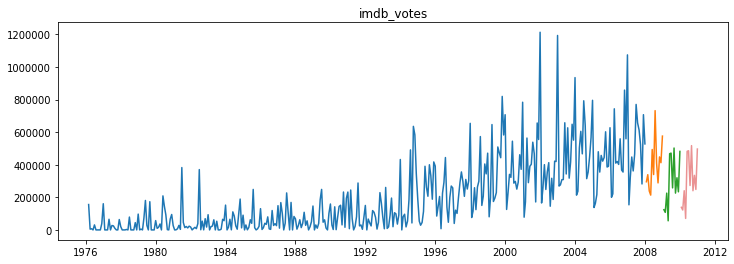

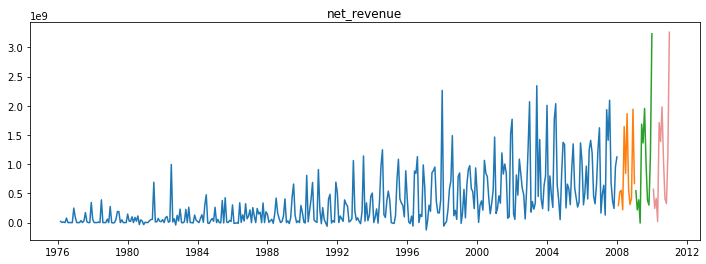

In [63]:
for col in train.columns:
    final_plot(col)

In [64]:
from vega_datasets import data
movie = data('movies')


movie.columns = [column.lower() for column in movie]
movie.columns = movie.columns.str.replace(' ','_')
movie = movie.drop(columns=['us_gross', 'us_dvd_sales', 'mpaa_rating', 
                 'running_time_min', 'source', 'major_genre',
                'creative_type', 'director', 'distributor', 
                 'rotten_tomatoes_rating', 'imdb_rating'])
movie = movie.dropna()
movie['net_revenue'] = movie.worldwide_gross - movie.production_budget
movie = movie.drop(columns=['worldwide_gross', 'production_budget', 'title'])
movie.release_date = pd.to_datetime(movie.release_date)
movie = movie.set_index('release_date').sort_index()
movie = movie.resample('M').sum()

movie.head(2)

,imdb_votes,net_revenue
release_date,,
1928-12-31,2017.0,3979000.0
1929-01-31,0.0,0.0


In [138]:
# get residuals for 2010: revenue
r_pred_2010 = yhat_df['net_revenue'].resample('m').sum()[:-3]
r_actual_2010 = movie.net_revenue['2010'][:-3]
r_resid_2010 = abs(r_actual_2010 - r_pred_2010)

In [139]:
# get residuals for 2010: votes
v_pred_2010 = yhat_df['imdb_votes'].resample('m').sum()[:-3]
v_actual_2010 = movie.imdb_votes['2010'][:-3]
v_resid_2010 = abs(v_actual_2010 - v_pred_2010)

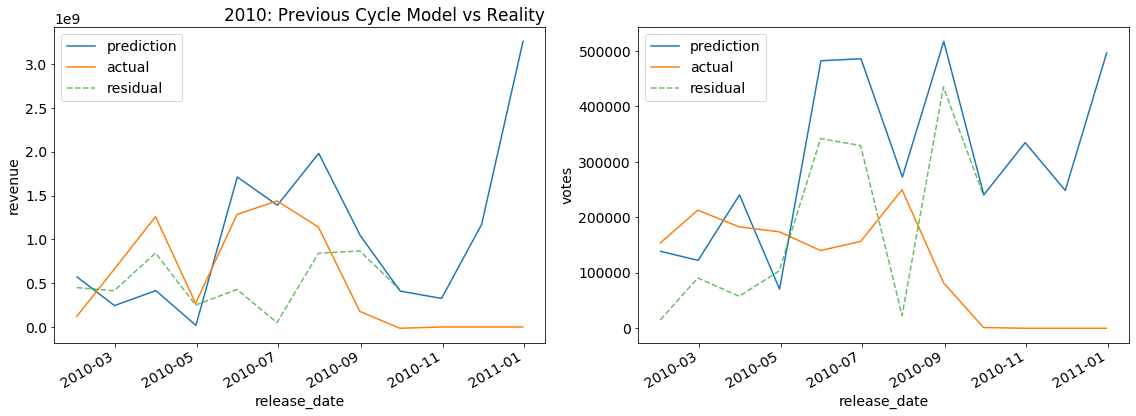

In [147]:
plt.figure(figsize=(16,6))
plt.rc('font', size=14)

plt.subplot(121)
plt.title('2010: Previous Cycle Model vs Reality', loc='right')
plt.plot(yhat_df['net_revenue'], label='prediction')
movie.net_revenue['2010'].plot(label='actual')
plt.plot(r_resid_2010, label='residual', linestyle='--', alpha=.7)
plt.ylabel('revenue')
plt.legend()
           
plt.subplot(122)
plt.plot(yhat_df['imdb_votes'], label='prediction')
movie.imdb_votes['2010'].plot(label='actual')
plt.plot(v_resid_2010, label='residual', linestyle='--', alpha=.7)
plt.ylabel('votes')
plt.legend()
plt.tight_layout()

Takeaways:
- 